In [1]:
from IPython.display import clear_output

!pip install pmdarima
!pip install streamlit
!pip install netCDF4

clear_output(wait=False)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import itertools
from math import sqrt
import matplotlib.pyplot as plt
import math

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

import datetime
from dateutil.relativedelta import relativedelta
import time

import streamlit as st
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

import xarray as xr
import netCDF4

In [4]:
sst_bck = xr.open_dataset('/content/drive/My Drive/sst.mon.mean.nc')['sst']
slp_bck = xr.open_dataset('/content/drive/My Drive/slp.nc',decode_times=False)

In [5]:
new_time = slp_bck['T'].to_numpy()
date_ref = datetime.date(1949,1,1)

new_time  = [date_ref+relativedelta(months=+math.floor(i)+132) for i in new_time]
new_time = [np.datetime64(i) for i in new_time]
slp_bck['T'] = ('T',new_time)
slp_bck = slp_bck['pressure']

In [6]:
sst_bck

<xarray.DataArray 'sst' (time: 519, lat: 720, lon: 1440)> Size: 2GB
[538099200 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 4kB 1981-09-01 1981-10-01 ... 2024-11-01
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Attributes:
    long_name:      Monthly Mean of Sea Surface Temperature
    units:          degC
    valid_range:    [-3. 45.]
    precision:      2.0
    dataset:        NOAA High-resolution Blended Analysis
    var_desc:       Sea Surface Temperature
    level_desc:     Surface
    statistic:      Monthly Mean
    parent_stat:    Individual Observations
    actual_range:   [-1.8  32.14]
    standard_name:  sea_surface_temperature

In [7]:
lat_boundary_top = 40
lat_bounday_bottom = 30
long_boundary_left = 310
long_boundary_right = 321

sst = sst_bck.where(sst_bck['lat']> lat_bounday_bottom,drop=True)
sst = sst.where(sst['lat']< lat_boundary_top,drop=True)
sst = sst.where(sst['lon']> long_boundary_left,drop=True)
sst = sst.where(sst['lon']< long_boundary_right,drop=True)

sst = sst.where(sst['time.year']> 1981,drop=True)
sst = sst.where(sst['time.year']< 2024,drop=True)

slp = slp_bck.where(slp_bck['Y']> lat_bounday_bottom,drop=True)
slp = slp.where(slp['Y']< lat_boundary_top,drop=True)
slp = slp.where(slp['X']> long_boundary_left,drop=True)
slp = slp.where(slp['X']< long_boundary_right,drop=True)

slp = slp.where(slp['T.year']> 1981,drop=True)
slp = slp.where(slp['T.year']< 2024,drop=True)

timestamps = sst.coords['time'].values
sst_means = sst.mean(dim=['lat','lon']).values
slp_means = slp.mean(dim=['Y','X']).values

In [8]:
sst

<xarray.DataArray 'sst' (time: 504, lat: 40, lon: 44)> Size: 4MB
array([[[20.75129 , 20.710968, 20.693226, ..., 20.58645 , 20.475805,
         20.36516 ],
        [20.72258 , 20.690645, 20.660967, ..., 20.505161, 20.41258 ,
         20.313547],
        [20.717419, 20.663225, 20.613226, ..., 20.331612, 20.280968,
         20.230967],
        ...,
        [17.58    , 17.721935, 17.71516 , ..., 16.850967, 16.799677,
         16.680967],
        [17.567097, 17.621935, 17.52387 , ..., 16.684193, 16.523548,
         16.364193],
        [17.564516, 17.519676, 17.329355, ..., 16.530323, 16.309032,
         16.10387 ]],

       [[19.823929, 19.79857 , 19.836784, ..., 19.943571, 19.984642,
         19.976786],
        [19.818571, 19.79857 , 19.831429, ..., 19.675   , 19.804285,
         19.818214],
        [19.796429, 19.773214, 19.801071, ..., 19.405357, 19.609999,
         19.665714],
...
        [22.167334, 22.293333, 22.373667, ..., 20.588667, 20.650333,
         20.704666],
        [21.306334, 21.575666, 21.789333, ..., 20.416666, 20.444332,
         20.463   ],
        [20.191   , 20.525665, 20.811333, ..., 20.357   , 20.323   ,
         20.304333]],

       [[23.459354, 23.447096, 23.440645, ..., 22.977741, 22.932903,
         22.932257],
        [23.365807, 23.326128, 23.279354, ..., 22.85129 , 22.819677,
         22.814194],
        [23.246773, 23.21129 , 23.179354, ..., 22.801935, 22.792257,
         22.785807],
        ...,
        [19.703226, 19.78774 , 19.849354, ..., 18.407097, 18.391935,
         18.438065],
        [18.813225, 18.910645, 19.044516, ..., 18.250967, 18.191612,
         18.221613],
        [17.925806, 17.979677, 18.117096, ..., 18.139677, 18.052902,
         18.063871]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1982-01-01 1982-02-01 ... 2023-12-01
  * lat      (lat) float32 160B 30.12 30.38 30.62 30.88 ... 39.38 39.62 39.88
  * lon      (lon) float32 176B 310.1 310.4 310.6 310.9 ... 320.4 320.6 320.9
Attributes:
    long_name:      Monthly Mean of Sea Surface Temperature
    units:          degC
    valid_range:    [-3. 45.]
    precision:      2.0
    dataset:        NOAA High-resolution Blended Analysis
    var_desc:       Sea Surface Temperature
    level_desc:     Surface
    statistic:      Monthly Mean
    parent_stat:    Individual Observations
    actual_range:   [-1.8  32.14]
    standard_name:  sea_surface_temperature

In [9]:
data = pd.DataFrame(columns=['Time','SST','SLP'])
data['Time'] = timestamps
data['SST'] = sst_means
data['SLP'] = slp_means

data['Time'] = pd.to_datetime(data['Time'], format='%y%m%d')
data = data.set_index('Time')

<Figure size 1000x600 with 0 Axes>

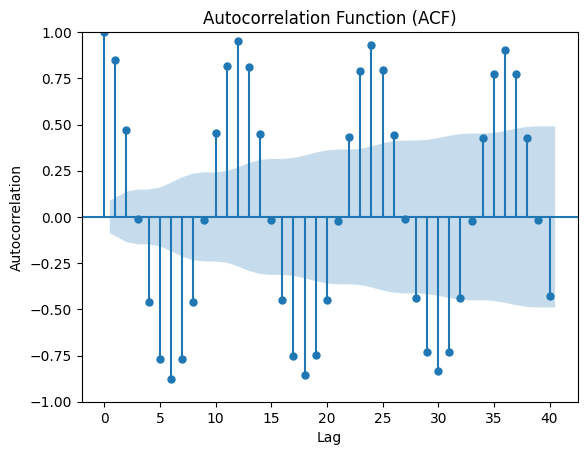

<Figure size 1000x600 with 0 Axes>

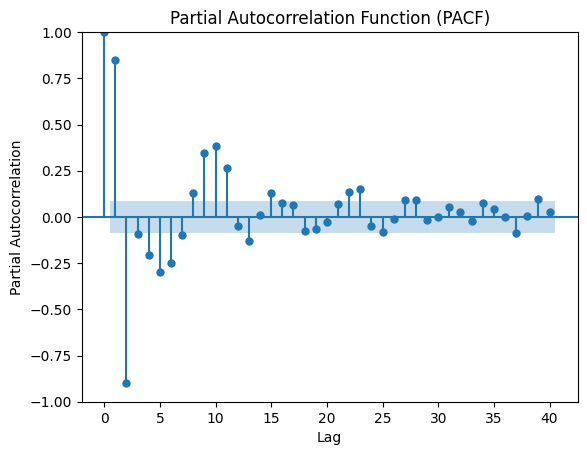

In [10]:
plt.figure(figsize=(10, 6))
plot_acf(data['SST'], lags=40)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.savefig('Atlantic_ACF_1.png')
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(data['SST'], lags=40)
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.savefig('Atlantic_PACF_1.png')
plt.show()

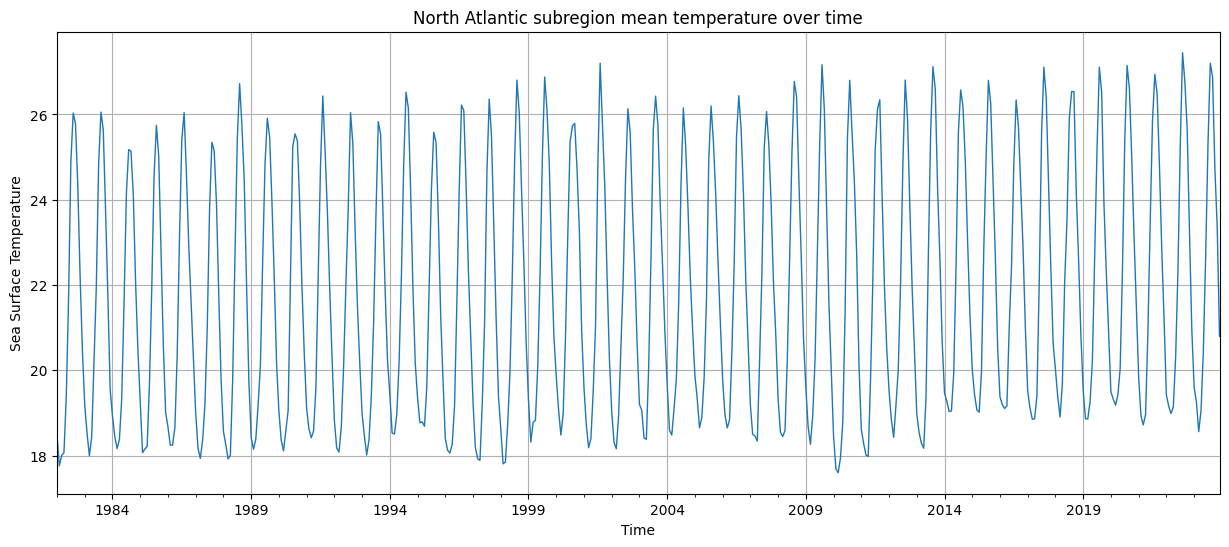

In [11]:
data['SST'].plot(grid=True, figsize=(15,6), linewidth=1)
plt.title('North Atlantic subregion mean temperature over time')
plt.ylabel('Sea Surface Temperature')
plt.savefig('Atlantic_data.png')
plt.show()

In [12]:
print(f"P-value: {adfuller(data['SST'], autolag='AIC')[1]}")
print(f"Critical Value: {adfuller(data['SST'], autolag='AIC')[0]}")
print(f"Confidence Intervals: {adfuller(data['SST'], autolag='AIC')[-2]}")

P-value: 0.10165700930006133
Critical Value: -2.55951342290454
Confidence Intervals: {'1%': -3.4437660979098843, '5%': -2.8674565460819896, '10%': -2.569921291128696}


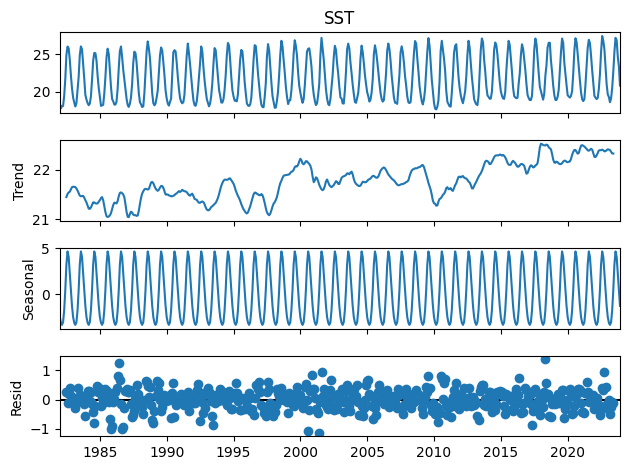

In [13]:
decomposition = seasonal_decompose(data['SST'], model='additive', period=12)
fig = decomposition.plot()
fig.savefig('Atlantic_decomposition.png')

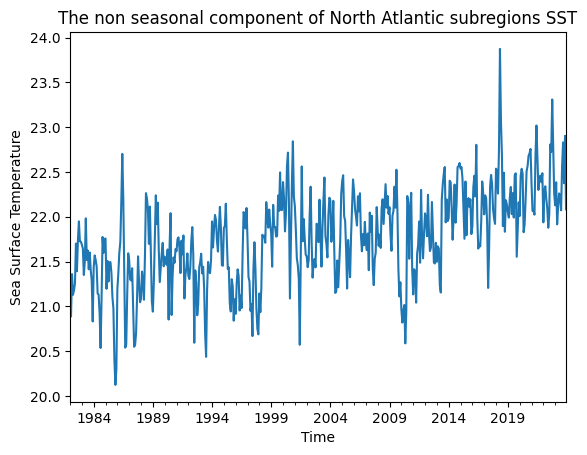

In [14]:
seasonal_adj = decomposition.observed - decomposition.seasonal
fig = seasonal_adj.plot()
fig.set_ylabel('Sea Surface Temperature')
fig.set_title('The non seasonal component of North Atlantic subregions SST')
plt.show()

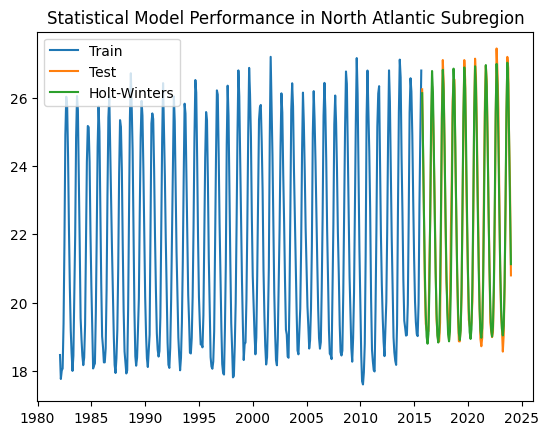

In [15]:
n = int(data.shape[0] * 0.2)
data = data.resample('M').mean()
train, test = data['SST'].iloc[:-n], data['SST'].iloc[-n:]

model = ExponentialSmoothing(train, freq='M', trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()
prediction = model_fit.predict(start=test.index[0], end=test.index[-1])

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(prediction.index, prediction, label='Holt-Winters')
plt.legend(loc='best')
plt.title('Statistical Model Performance in North Atlantic Subregion')
plt.show()

In [16]:
rmse = sqrt(mean_squared_error(test, prediction))
r2 = r2_score(test,prediction)
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 0.3771442094869921
R2: 0.9827115144209427


<Figure size 1000x600 with 0 Axes>

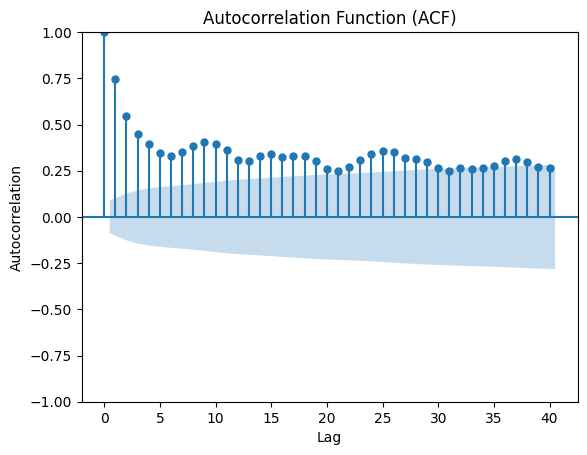

<Figure size 1000x600 with 0 Axes>

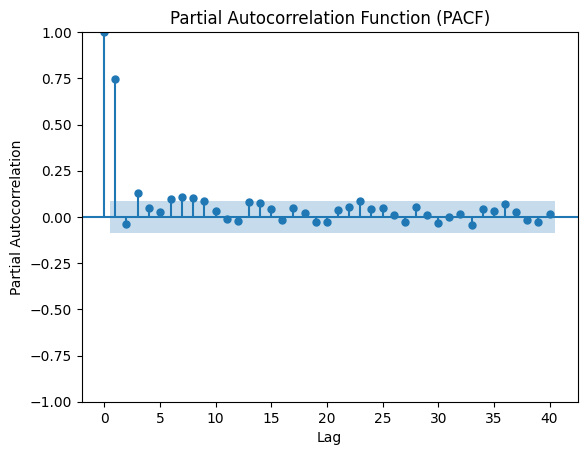

In [17]:
x = decomposition.observed - decomposition.seasonal

plt.figure(figsize=(10, 6))
plot_acf(x, lags=40)
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.savefig('Atlantic_ACF_2.png')
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(x, lags=40)
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag")
plt.ylabel("Partial Autocorrelation")
plt.savefig('Atlantic_PACF_2.png')
plt.show()

In [18]:
print(f"P-value: {adfuller(x, autolag='AIC')[1]}")
print(f"Critical Value: {adfuller(x, autolag='AIC')[0]}")
print(f"Confidence Intervals: {adfuller(x, autolag='AIC')[-2]}")

P-value: 0.012784709636901667
Critical Value: -3.350036694079191
Confidence Intervals: {'1%': -3.4436298692815304, '5%': -2.867396599893435, '10%': -2.5698893429241916}


In [19]:
stepwise_model = auto_arima(x, stepwise=True, trace=True, stationary=True,seasonal=False)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=359.573, Time=9.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=778.391, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=363.047, Time=0.99 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=496.908, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4537.661, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=356.176, Time=5.02 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=420.129, Time=1.37 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=364.221, Time=2.40 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=350.456, Time=1.21 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=401.323, Time=0.36 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=353.378, Time=1.45 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=350.576, Time=1.54 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=384.484, Time=0.37 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=352.813, Time=1.77 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=345.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  504
Model:               SARIMAX(1, 0, 5)   Log Likelihood                -164.383
Date:                Thu, 12 Dec 2024   AIC                            342.766
Time:                        20:16:33   BIC                            372.324
Sample:                    01-01-1982   HQIC                           354.360
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   2.99e-05   3.35e+04      0.000       1.000       1.000
ma.L1         -0.2833      0.042     -6.736      0.000      -0.366      -0.201
ma.L2         -0.3416      0.045     -7.603      0.000      -0.430      -0.254
ma.L3         -0.1507      0.046     -3.255      0.001      -0.241      -0.060
ma.L4         -0.0505      0.051     -0.987      0.323      -0.151       0.050
ma.L5         -0.0900      0.045     -2.018      0.044      -0.177      -0.003
sigma2         0.1103      0.007     16.132      0.000       0.097       0.124
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.94
Prob(Q):                              0.90   Prob(JB):                         0.62
Heteroskedasticity (H):               1.17   Skew:                             0.00
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
params = stepwise_model.get_params()
order = params['order']
seasonal_order = params['seasonal_order']

train, test = x.iloc[:-n], x.iloc[-n:]

model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)

model_fit = model.fit()
start = len(train)
end = len(train) + len(test) - 1
prediction2 = model_fit.predict(start=start, end=end)
prediction2 = prediction2.rename('Prediction')

In [21]:
stepwise_model = auto_arima(data['SST'], stepwise=True, m=12, trace=True, stationary=False,exogenous=data['SLP'])
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=780.633, Time=6.84 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2500.516, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=2.71 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1524.493, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4546.118, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=842.872, Time=3.47 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=760.291, Time=3.08 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=918.532, Time=1.00 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=660.468, Time=16.71 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=19.68 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=603.173, Time=8.35 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=721.628, Time=2.77 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=550.316, Time=10.43 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=538.535, Time=3.65 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  504
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -220.376
Date:                            Thu, 12 Dec 2024   AIC                            452.753
Time:                                    20:19:54   BIC                            478.088
Sample:                                01-31-1982   HQIC                           462.691
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0278      0.014      2.040      0.041       0.001       0.055
ar.L1          0.5719      0.050     11.507      0.000       0.475       0.669
ma.L1          0.1861      0.059      3.146      0.002       0.070       0.302
ar.S.L12       0.9970      0.001    716.950      0.000       0.994       1.000
ma.S.L12      -0.7940      0.040    -19.775      0.000      -0.873      -0.715
sigma2         0.1248      0.008     16.438      0.000       0.110       0.140
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.85
Prob(Q):                              0.95   Prob(JB):                         0.05
Heteroskedasticity (H):               1.14   Skew:                             0.14
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
params = stepwise_model.get_params()
order = params['order']
seasonal_order = params['seasonal_order']

train, test = data['SST'].iloc[:-n], data['SST'].iloc[-n:]

model = SARIMAX(train, exog=data['SLP'].iloc[:-n],order=order, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)

model_fit = model.fit()
start = len(train)
end = len(train) + len(test) - 1
prediction3 = model_fit.predict(start=start, end=end,exog=data['SLP'].iloc[-n:])
prediction3 = prediction3.rename('Prediction')
# prediction.index = series.index[start:end+1]

In [23]:
stepwise_model = auto_arima(data['SST'], stepwise=True, m=12, trace=True, stationary=False)
stepwise_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=780.633, Time=8.05 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2500.516, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1524.493, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=4546.118, Time=0.04 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=842.872, Time=3.56 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=760.291, Time=7.39 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=918.532, Time=0.99 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=660.468, Time=8.21 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=11.76 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=603.173, Time=8.13 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=721.628, Time=4.77 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=550.316, Time=6.86 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=538.535, Time=8.69 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  504
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -220.376
Date:                            Thu, 12 Dec 2024   AIC                            452.753
Time:                                    20:23:13   BIC                            478.088
Sample:                                01-31-1982   HQIC                           462.691
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0278      0.014      2.040      0.041       0.001       0.055
ar.L1          0.5719      0.050     11.507      0.000       0.475       0.669
ma.L1          0.1861      0.059      3.146      0.002       0.070       0.302
ar.S.L12       0.9970      0.001    716.950      0.000       0.994       1.000
ma.S.L12      -0.7940      0.040    -19.775      0.000      -0.873      -0.715
sigma2         0.1248      0.008     16.438      0.000       0.110       0.140
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.85
Prob(Q):                              0.95   Prob(JB):                         0.05
Heteroskedasticity (H):               1.14   Skew:                             0.14
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
params = stepwise_model.get_params()
order = params['order']
seasonal_order = params['seasonal_order']

train, test = data['SST'].iloc[:-n], data['SST'].iloc[-n:]

model = SARIMAX(train, order=order, m=12, seasonal_order=seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)

model_fit = model.fit()
start = len(train)
end = len(train) + len(test) - 1
prediction4 = model_fit.predict(start=start, end=end)
prediction4 = prediction4.rename('Prediction')

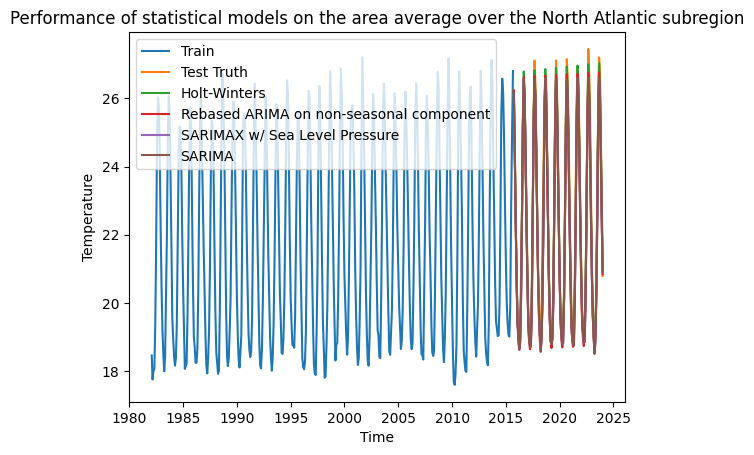

In [25]:
plt.plot(train.index,train,label='Train')
plt.plot(test.index, test, label='Test Truth')
plt.plot(test.index, prediction, label='Holt-Winters')
plt.plot(test.index, [a+b for a,b in zip(prediction2.values,decomposition.seasonal.values[-n:])], label='Rebased ARIMA on non-seasonal component')
plt.plot(test.index, prediction3, label='SARIMAX w/ Sea Level Pressure')
plt.plot(test.index, prediction3, label='SARIMA')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Performance of statistical models on the area average over the North Atlantic subregion')
plt.show()

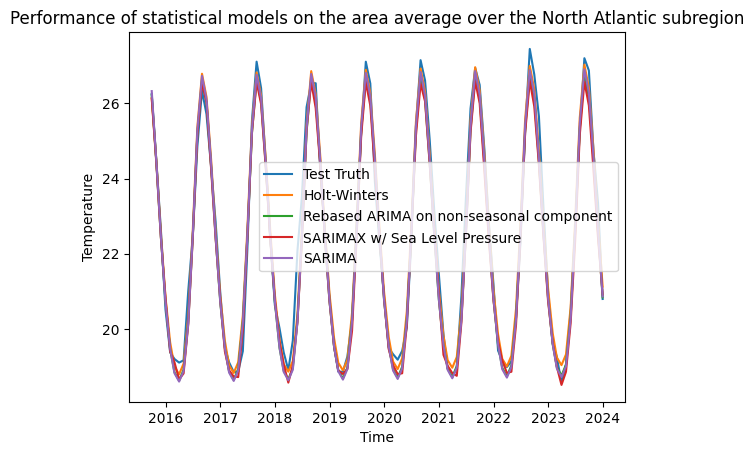

In [26]:
#plt.plot(train.index,train,label='Train')
plt.plot(test.index, test, label='Test Truth')
plt.plot(test.index, prediction, label='Holt-Winters')
plt.plot(test.index, [a+b for a,b in zip(prediction2.values,decomposition.seasonal.values[-n:])], label='Rebased ARIMA on non-seasonal component')
plt.plot(test.index, prediction3, label='SARIMAX w/ Sea Level Pressure')
plt.plot(test.index, prediction4, label='SARIMA')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Performance of statistical models on the area average over the North Atlantic subregion')
plt.savefig('Atlantic_statistical.png')
plt.show()

In [27]:
rmse = sqrt(mean_squared_error(test, prediction))
r2 = r2_score(test,prediction)
mae = (mean_absolute_error(test, prediction))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.290399855842163
RMSE: 0.3771442094869921
R2: 0.9827115144209427


In [28]:
rmse = sqrt(mean_squared_error(test, [a+b for a,b in zip(prediction2.values,decomposition.seasonal.values[-n:])]))
r2 = r2_score(test,[a+b for a,b in zip(prediction2.values,decomposition.seasonal.values[-n:])])
mae = (mean_absolute_error(test, [a+b for a,b in zip(prediction2.values,decomposition.seasonal.values[-n:])]))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.3248658218854008
RMSE: 0.4408146891504581
R2: 0.9763814210891724


In [29]:
rmse = sqrt(mean_squared_error(test, prediction3))
r2 = r2_score(test,prediction3)
mae = (mean_absolute_error(test, prediction3))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.3603320338277116
RMSE: 0.47748327632416043
R2: 0.9722886046639114


In [30]:
rmse = sqrt(mean_squared_error(test, prediction4))
r2 = r2_score(test,prediction4)
mae = (mean_absolute_error(test, prediction4))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

MAE: 0.3148210904133448
RMSE: 0.4256640848590532
R2: 0.9779770201949005


In [31]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,GRU

In [32]:
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R^2": r2}

In [33]:
time_series = data['SST'].values
split_index = data.shape[0]-n

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(time_series.reshape(-1, 1))

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

sequence_length = 10#len(test_data)  # Use 10 timesteps for prediction
X, y = create_sequences(scaled_data, sequence_length)

# Split into train and test sets
X_train, X_test = X[:split_index-sequence_length], X[split_index-sequence_length:]
y_train, y_test = y[:split_index-sequence_length], y[split_index-sequence_length:]

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

lstm_metrics = evaluate_model(y_test_rescaled, lstm_predictions)
lstm_metrics['Model'] = 'LSTM'
print(lstm_metrics)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2265
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1318
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0982
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0920
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0822
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0750
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0637
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0596
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0439
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0197
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0056
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040
Epoch 16/20
13/13 ━

In [34]:
bilstm_model = Sequential([
    Bidirectional(LSTM(50, activation='relu'), input_shape=(sequence_length, 1)),  # Bidirectional LSTM
    Dense(1)
])
bilstm_model.compile(optimizer='adam', loss='mse')

# Train the model
bilstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
bilstm_predictions = bilstm_model.predict(X_test)
bilstm_predictions = scaler.inverse_transform(bilstm_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

bilstm_metrics = evaluate_model(y_test_rescaled, bilstm_predictions)
bilstm_metrics['Model'] = 'BiLSTM'
print(bilstm_metrics)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2570
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1352
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0985
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0848
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0736
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0651
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0404
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0184
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0086
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0077
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0061
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0050
Epoch 1

In [35]:
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, 1)),  # GRU layer
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)  # Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))  # Rescale true values

gru_metrics = evaluate_model(y_test_rescaled, gru_predictions)
gru_metrics['Model'] = 'GRU'
print(gru_metrics)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2382
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1517
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0843
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0766
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0639
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0586
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0479
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0405
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0303
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0198
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0112
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0073
Epoch 13/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0061
Epoch 14/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0049
Epoch 15/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0046
Epoch 16/20


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
{'MAE': 0.76344496, 'RMSE': 0.9313916, 'R^2': 0.8945596814155579, 'Model': 'GRU'}


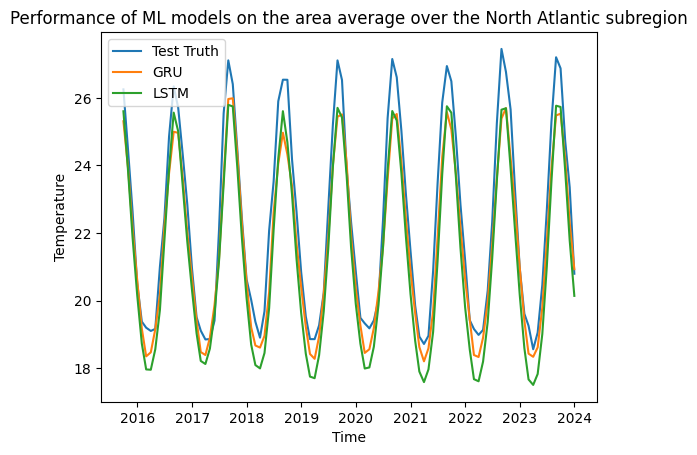

In [36]:
#plt.plot(train.index,train,label='Train')
plt.plot(test.index, test, label='Test Truth')
#plt.plot(test.index, prediction, label='Holt-Winters')
#plt.plot(test.index, [a+b for a,b in zip(prediction2.values,decomposition.seasonal.values[-n:])], label='Rebased ARIMA on non-seasonal component')
#plt.plot(test.index, prediction3, label='SARIMAX w/ Sea Level Pressure')
#plt.plot(test.index, prediction4, label='SARIMA')
plt.plot(test.index, gru_predictions, label='GRU')
plt.plot(test.index, lstm_predictions, label='LSTM')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Performance of ML models on the area average over the North Atlantic subregion')
plt.savefig('Atlantic_ML.png')
plt.show()